In [1]:
from utils import Polarity

import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.patches as mpatches

sns.set_style("whitegrid", {'grid.linestyle': '--'})

In [2]:
df = pd.read_csv('../political_news.csv', parse_dates=['date'])
vecs = np.load('../training/bestmod_vecs.npy')

polarity_obj = Polarity(df, vecs, period_length='1d', standartize_vecs=True)
polarity_df = polarity_obj.get_polarity()

In [3]:
colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    '#bcbd22',  # olive
    '#17becf',  # light blue
    '#ff9896',  # light orange
    '#98df8a',  # light green
    '#ffbb78',  # light red
    '#c5b0d5',  # light purple
    '#c49c94'   # light brown
]
comb_colors_dict = {v:k for v,k in zip(polarity_obj.combs, colors)}

In [4]:
polarity_df['D_rolling'] = polarity_df.groupby('comb', group_keys=False)['D'].apply(lambda x: x.rolling(30).mean())
polarity_df['B_rolling'] = polarity_df.groupby('comb', group_keys=False)['B'].apply(lambda x: x.rolling(30).mean())
polarity_df['cluster'] = polarity_df['between_combs'].map({True:'Between', False:'Within'})

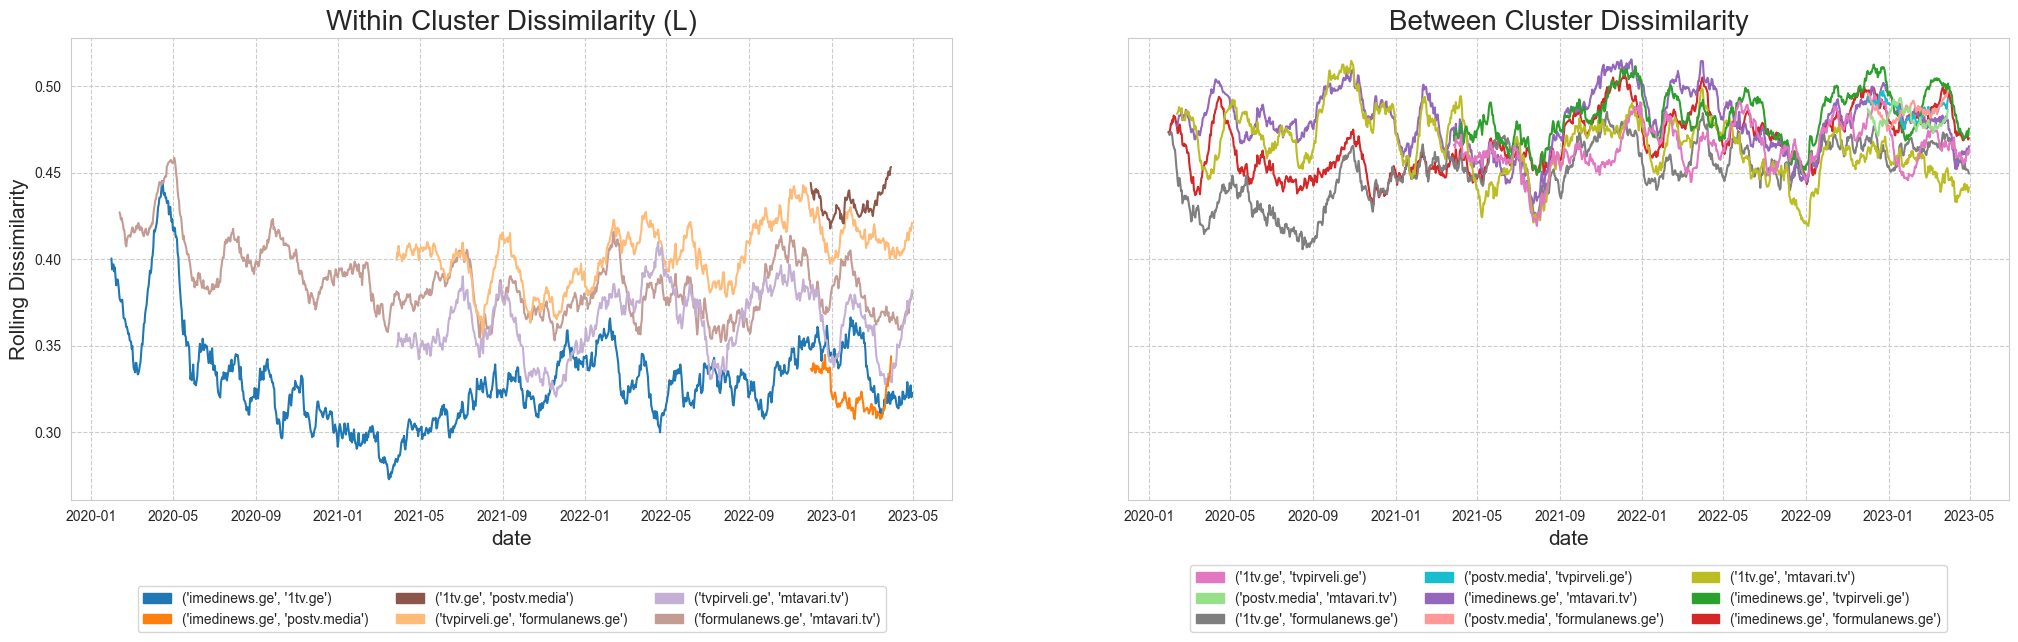

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[25, 6], sharey=True)
sns.lineplot(data=polarity_df[polarity_df['cluster'] == 'Within'],
                x='date',
                y='D_rolling',
                hue='comb',
                palette=comb_colors_dict,
                ax=axes[0])
legend_labels = polarity_obj.within_combs
legend_colors = [comb_colors_dict[label] for label in legend_labels] 
patch_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
axes[0].legend(handles=patch_handles, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
axes[0].set_title('Within Cluster Dissimilarity (L)', fontsize=20)
axes[0].set_ylabel('Rolling Dissimilarity', fontsize=15)
axes[0].set_xlabel('date', fontsize=15)


sns.lineplot(data=polarity_df[polarity_df['cluster'] == 'Between'],
                x='date',
                y='D_rolling',
                hue='comb',
                palette=comb_colors_dict,
                ax=axes[1])

legend_labels = polarity_obj.between_combs
legend_colors = [comb_colors_dict[label] for label in legend_labels] 
patch_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
axes[1].legend(handles=patch_handles, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
axes[1].set_title('Between Cluster Dissimilarity', fontsize=20)
axes[1].set_xlabel('date', fontsize=15)

plt.savefig('within_between_diss.png', bbox_inches='tight');

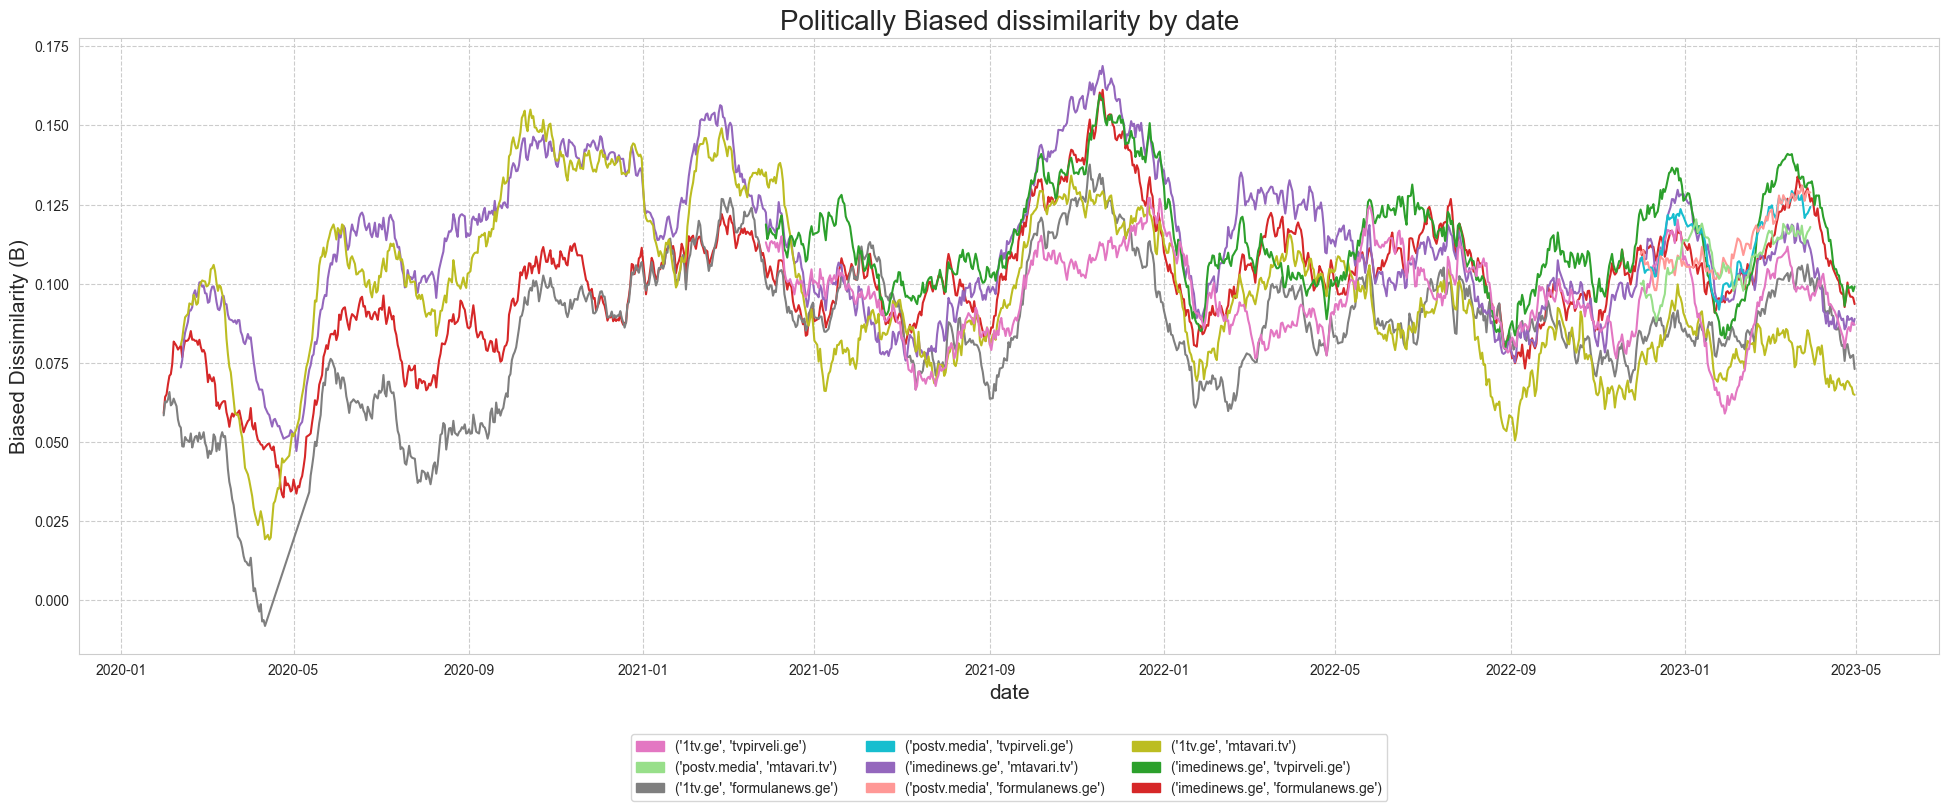

In [6]:
fig, ax = plt.subplots(figsize=[24,8])
sns.lineplot(data=polarity_df[polarity_df['between_combs']], x='date', y='B_rolling', hue='comb',
            palette=comb_colors_dict, ax=ax)

legend_labels = polarity_obj.between_combs
legend_colors = [comb_colors_dict[label] for label in legend_labels] 
patch_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
ax.legend(handles=patch_handles, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)

plt.xlabel('date', fontsize=15)
plt.ylabel('Biased Dissimilarity (B)', fontsize=15)
plt.title('Politically Biased dissimilarity by date', fontsize=20)
plt.savefig('biased_diss.png', bbox_inches='tight');

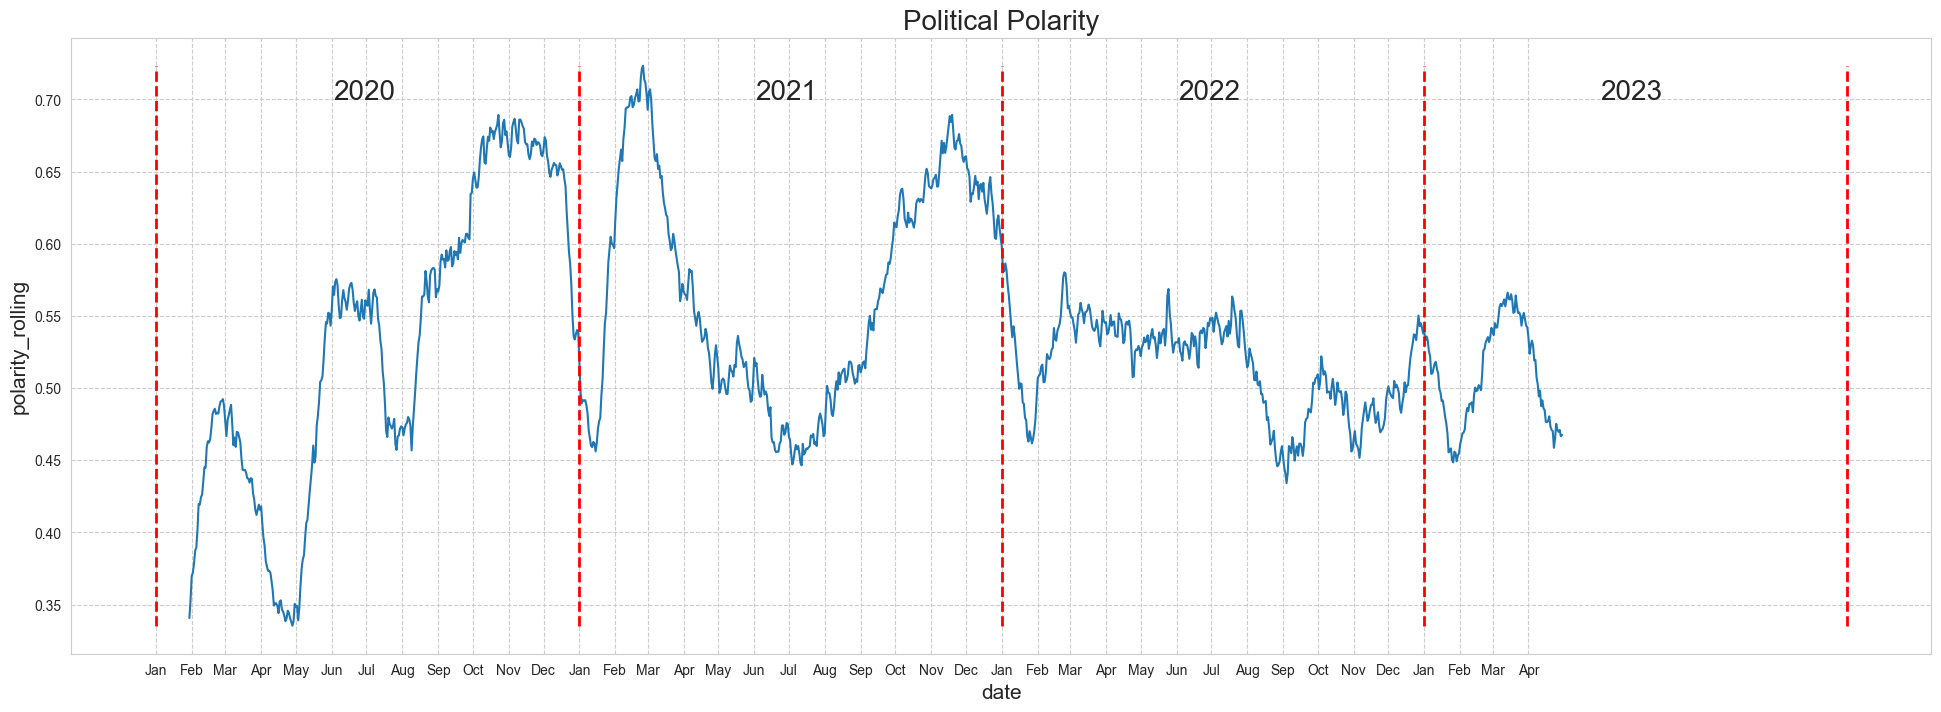

In [7]:
def normalize_column(col):
    return (col - col.min())/(col.max()-col.min())

agg_polarity = polarity_df.groupby('date').agg({'polarity':'sum'})
agg_polarity['polarity'] = normalize_column(agg_polarity['polarity'])
agg_polarity['polarity_rolling'] = agg_polarity['polarity'].rolling(30).mean()

fig, ax = plt.subplots(figsize=[24,8])
sns.lineplot(agg_polarity, x='date', y='polarity_rolling', ax=ax)

for year in [2020, 2021, 2022, 2023, 2024]:
    ax.plot([datetime(year, 1, 1), datetime(year, 1, 1)],
            [agg_polarity['polarity_rolling'].min(), agg_polarity['polarity_rolling'].max()], c='r', lw=2, linestyle='--')
    ax.annotate(year, xy=(datetime(year,6, 2), 0.7), fontsize=20)
    
ax.set_xticks([date for date in agg_polarity.index if date.day == 1])
ax.set_xticklabels([date.strftime('%b') for date in agg_polarity.index if date.day == 1])
ax.grid(True, linestyle='--')
ax.set_xlabel('date', fontsize=15)
ax.set_ylabel('polarity_rolling', fontsize=15)
ax.set_title('Political Polarity', fontsize=20)
plt.savefig('polarity.png', bbox_inches='tight');

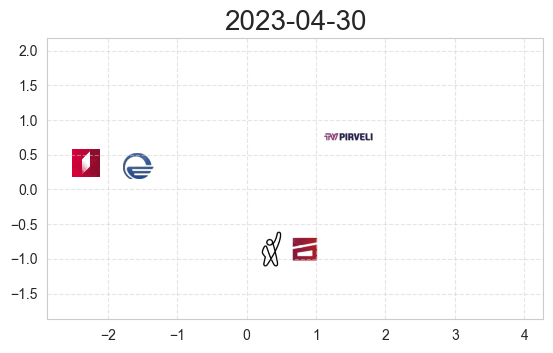

In [8]:
polarity_obj.save_animation()